# **AEGIS LENS EXPLORATORY DATA ANALYSIS**

## i. Import Libraries

Pada tahap ini kita akan melakukan import libraries yang di perlukan untuk kebutuhan Exploratory Data Analysis. Library ini akan terus update tergantung apa yang akan kita eksplor dibawah.

In [ ]:
#Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import random
import cv2

## ii. Split Data Train and Val

Pada tahap ini kita akan melakukan split dataset menjadi 2 bagian, yaitu train dan validation. Kita membagi dataset menjadi 80 % untuk data train dan 20 % untuk data validation.

In [10]:
#Split Train dan Val
base_dir = "Dataset"
images_dir = os.path.join(base_dir, "images")
labels_dir = os.path.join(base_dir, "labels")

output_dirs = {
    "train": 0.8,
    "val": 0.2,
}

for split in output_dirs:
    os.makedirs(os.path.join(base_dir, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(base_dir, split, "labels"), exist_ok=True)

image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

total = len(image_files)
start = 0
for split, ratio in output_dirs.items():
    count = int(total * ratio)
    selected_files = image_files[start:start + count]
    for file in selected_files:
        src_img = os.path.join(images_dir, file)
        dst_img = os.path.join(base_dir, split, "images", file)
        shutil.copy(src_img, dst_img)

        label_file = file.rsplit('.', 1)[0] + ".txt"
        src_label = os.path.join(labels_dir, label_file)
        dst_label = os.path.join(base_dir, split, "labels", label_file)
        if os.path.exists(src_label):
            shutil.copy(src_label, dst_label)

    start += count

## iii. Loading Data for EDA

Pada tahap ini kita akan loading dataset train yang sudah di split dari dataset utama. Dataset train inilah yang akan kita analisis, dimana diharapkan hasil analisis ini dapat membantu kita dalam pembuatan model.

In [ ]:
#Dataset Train path
images_dir = 'Dataset/train/images'
labels_dir = 'Dataset/train/labels'

In [ ]:
#Melihat Semua Label/Class
classes_path = 'Dataset/classes.txt'

with open(classes_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

print("Class Names:")
for idx, class_name in enumerate(classes):
    print(f"{idx}: {class_name}")

Class Names:
0: Bus
1: Car
2: LicensePlate
3: Motorcycle
4: Truck


Insight : Terdapat 5 Class/Label, yaitu :
0 untuk Bus
1 untuk Car
2 untuk LicensePlate
3 untuk

In [ ]:
#Loading data train
records = []

image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
for image_file in image_files:
    image_path = os.path.join(images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt')
    label_path = os.path.join(labels_dir, label_file)

    if not os.path.exists(label_path):
        continue

    image = plt.imread(image_path)
    h, w = image.shape[:2]

    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            records.append({
                'image': image_file,
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height,
                'area': width * height,
                'aspect_ratio': width / height if height != 0 else 0
            })

df = pd.DataFrame(records)

## iv. EDA

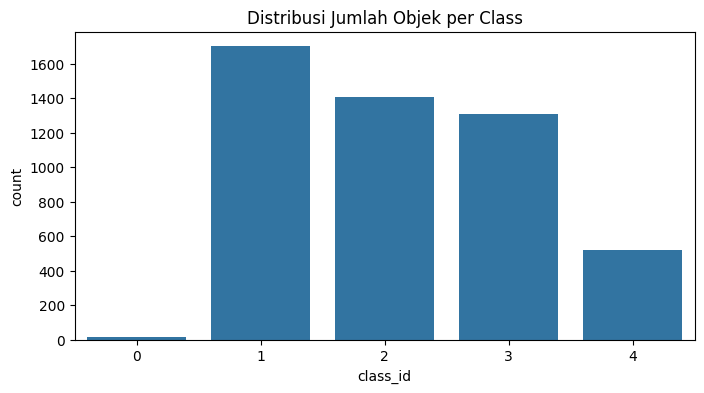

In [ ]:
# Distribusi jumlah objek per class
plt.figure(figsize=(8,4))
sns.countplot(x='class_id', data=df)
plt.title('Distribusi Jumlah Objek per Class')
plt.show()

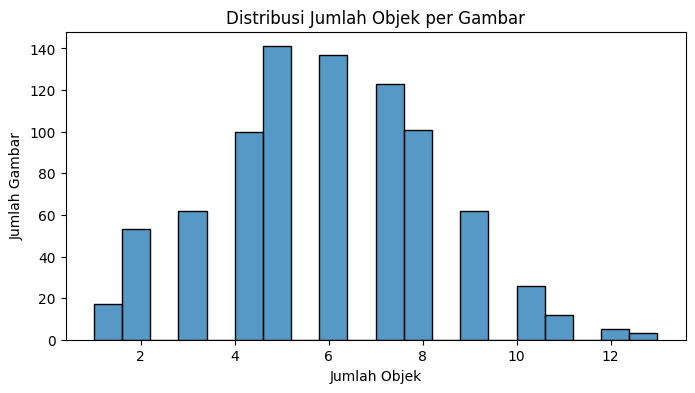

In [ ]:
# Distribusi jumlah objek per gambar
obj_per_image = df.groupby('image').size()
plt.figure(figsize=(8,4))
sns.histplot(obj_per_image, bins=20, kde=False)
plt.title('Distribusi Jumlah Objek per Gambar')
plt.xlabel('Jumlah Objek')
plt.ylabel('Jumlah Gambar')
plt.show()

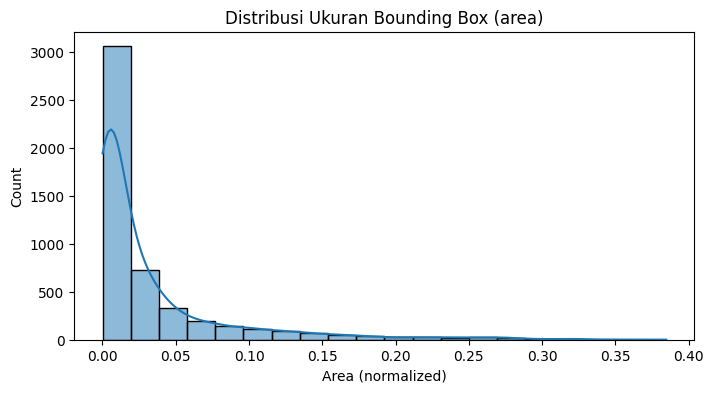

In [24]:
# 3️⃣ Distribusi ukuran bbox (area)
plt.figure(figsize=(8,4))
sns.histplot(df['area'], bins=20, kde=True)
plt.title('Distribusi Ukuran Bounding Box (area)')
plt.xlabel('Area (normalized)')
plt.show()

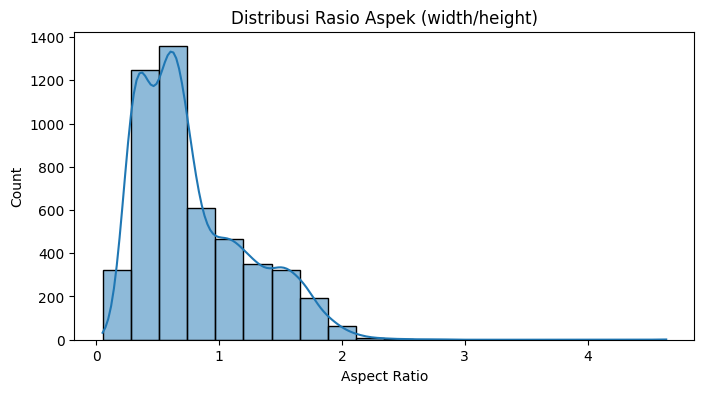

In [ ]:
# Distribusi rasio aspek bbox
plt.figure(figsize=(8,4))
sns.histplot(df['aspect_ratio'], bins=20, kde=True)
plt.title('Distribusi Rasio Aspek (width/height)')
plt.xlabel('Aspect Ratio')
plt.show()

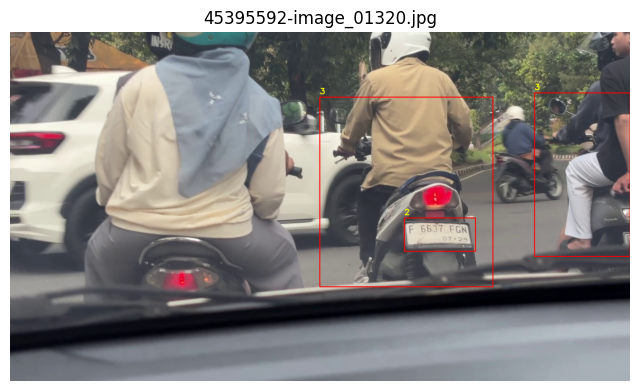

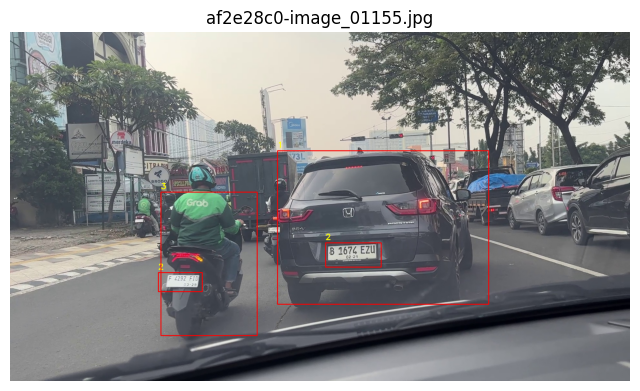

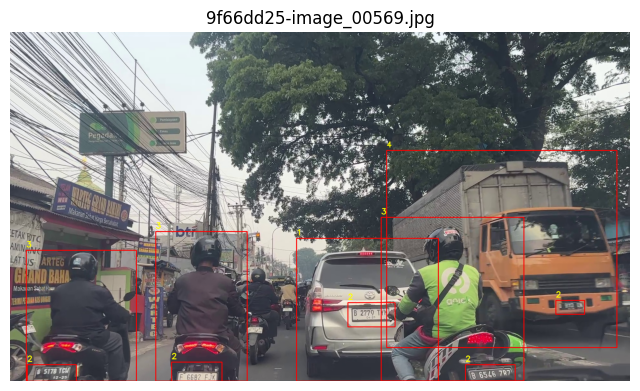

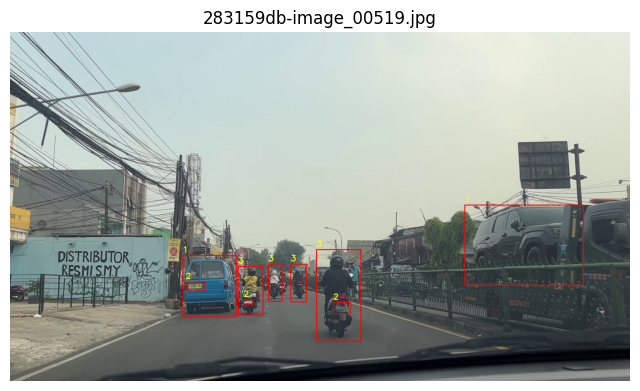

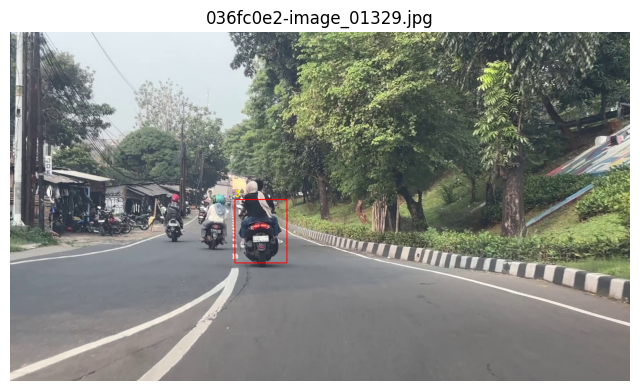

In [ ]:
# Visualisasi 5 gambar random + bbox
sample_images = df['image'].unique()
sample_images = np.random.choice(sample_images, size=min(5, len(sample_images)), replace=False)

for image_file in sample_images:
    image_path = os.path.join(images_dir, image_file)
    label_path = os.path.join(labels_dir, image_file.replace('.jpg', '.txt'))

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape

    boxes = df[df['image']==image_file]
    for _, row in boxes.iterrows():
        xmin = int((row['x_center'] - row['width']/2) * w)
        ymin = int((row['y_center'] - row['height']/2) * h)
        xmax = int((row['x_center'] + row['width']/2) * w)
        ymax = int((row['y_center'] + row['height']/2) * h)
        class_id = row['class_id']

        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255,0,0), 2)
        cv2.putText(image, str(class_id), (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,0), 2)

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    plt.title(image_file)
    plt.axis('off')
    plt.show()

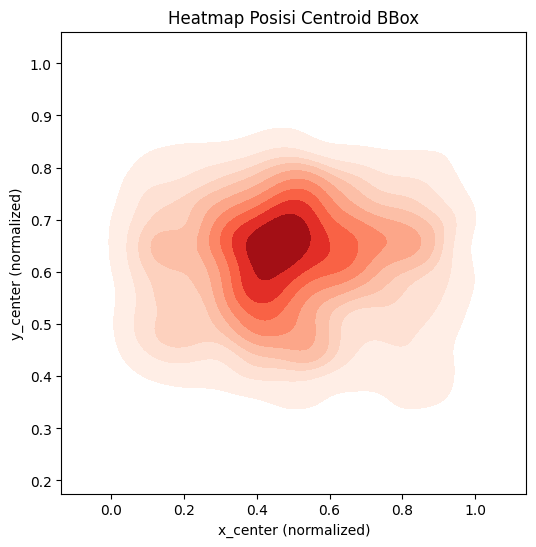

In [ ]:
# Heatmap sebaran posisi centroid bbox
plt.figure(figsize=(6,6))
sns.kdeplot(x=df['x_center'], y=df['y_center'], fill=True, cmap='Reds')
plt.title('Heatmap Posisi Centroid BBox')
plt.xlabel('x_center (normalized)')
plt.ylabel('y_center (normalized)')
plt.show()